In [1]:
# import necessary libraries and specify that graphs should be plotted inline
import numpy as np
import pandas as pd
pd.set_option('display.float_format', '{:.2f}'.format)
import sklearn
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import mean_absolute_error as mae
from sklearn.metrics import mean_squared_error as mse
from sklearn.metrics import r2_score
%matplotlib inline 
import warnings
warnings.filterwarnings('ignore')

In [2]:
# Load the dataset from the csv file:
raw_data = pd.read_csv('train-data.csv')
# shape of the dataframe
raw_data.shape

(6019, 14)

In [3]:
# variable names
raw_data.columns

Index(['Unnamed: 0', 'Name', 'Location', 'Year', 'Kilometers_Driven',
       'Fuel_Type', 'Transmission', 'Owner_Type', 'Mileage', 'Engine', 'Power',
       'Seats', 'New_Price', 'Price'],
      dtype='object')

In [4]:
# Get rid of the first column as it is only an index and with python we already have indexs
data = raw_data.drop(raw_data.columns[0], axis=1)

# Show the updated dataframe
data.head(10)

,Name,Location,Year,Kilometers_Driven,Fuel_Type,Transmission,Owner_Type,Mileage,Engine,Power,Seats,New_Price,Price
0,Maruti Wagon R LXI CNG,Mumbai,2010,72000,CNG,Manual,First,26.6 km/kg,998 CC,58.16 bhp,5.00,NaN,1.75
1,Hyundai Creta 1.6 CRDi SX Option,Pune,2015,41000,Diesel,Manual,First,19.67 kmpl,1582 CC,126.2 bhp,5.00,NaN,12.50
2,Honda Jazz V,Chennai,2011,46000,Petrol,Manual,First,18.2 kmpl,1199 CC,88.7 bhp,5.00,8.61 Lakh,4.50
3,Maruti Ertiga VDI,Chennai,2012,87000,Diesel,Manual,First,20.77 kmpl,1248 CC,88.76 bhp,7.00,NaN,6.00
4,Audi A4 New 2.0 TDI Multitronic,Coimbatore,2013,40670,Diesel,Automatic,Second,15.2 kmpl,1968 CC,140.8 bhp,5.00,NaN,17.74
5,Hyundai EON LPG Era Plus Option,Hyderabad,2012,75000,LPG,Manual,First,21.1 km/kg,814 CC,55.2 bhp,5.00,NaN,2.35
6,Nissan Micra Diesel XV,Jaipur,2013,86999,Diesel,Manual,First,23.08 kmpl,1461 CC,63.1 bhp,5.00,NaN,3.50
7,Toyota Innova Crysta 2.8 GX AT 8S,Mumbai,2016,36000,Diesel,Automatic,First,11.36 kmpl,2755 CC,171.5 bhp,8.00,21 Lakh,17.50
8,Volkswagen Vento Diesel Comfortline,Pune,2013,64430,Diesel,Manual,First,20.54 kmpl,1598 CC,103.6 bhp,5.00,NaN,5.20
9,Tata Indica Vista Quadrajet LS,Chennai,2012,65932,Diesel,Manual,Second,22.3 kmpl,1248 CC,74 bhp,5.00,NaN,1.95


# DATASET OVERVIEW

This notebook analyzes a dataset of used cars. The key variables included are:

- **Name**: The brand and model of the car.
- **Location**: The location in which the car is being sold or is available for purchase.
- **Year**: The year or edition of the model.
- **Kilometers_Driven**: The total kilometres driven in the car by the previous owner(s) in KM.
- **Fuel_Type**: The type of fuel used by the car. (Petrol / Diesel / Electric / CNG / LPG)
- **Transmission**: The type of transmission used by the car. (Automatic / Manual)
- **Owner_Type**: Whether the ownership is Firsthand, Second hand or other.
- **Mileage**: The standard mileage offered by the car company in kmpl or km/kg
- **Engine**: The displacement volume of the engine in cc.
- **Power**: The maximum power of the engine in bhp.
- **Seats**: The number of seats in the car.
- **New_Price**: The price of a new car of the same model.
- **Price**: The price of the car in INR Lakhs.

# DATA PREPROCESSING
First of all, lets focus on the target variable, **Price**, if we look closely we can cehck the currency of this price is in Indian rupees in Lakhs,
for a better insight we want to change to USD currency for the whole column:

In [5]:
# Conversion rate (1 USD = 83 INR approximately)
conversion_rate = 83

# Convert Price from INR Lakhs to USD
data['Price_USD'] = (data['Price'] * 100000) / conversion_rate
data.drop(columns=['Price'], inplace=True)
data.head()

,Name,Location,Year,Kilometers_Driven,Fuel_Type,Transmission,Owner_Type,Mileage,Engine,Power,Seats,New_Price,Price_USD
0,Maruti Wagon R LXI CNG,Mumbai,2010,72000,CNG,Manual,First,26.6 km/kg,998 CC,58.16 bhp,5.00,NaN,2108.43
1,Hyundai Creta 1.6 CRDi SX Option,Pune,2015,41000,Diesel,Manual,First,19.67 kmpl,1582 CC,126.2 bhp,5.00,NaN,15060.24
2,Honda Jazz V,Chennai,2011,46000,Petrol,Manual,First,18.2 kmpl,1199 CC,88.7 bhp,5.00,8.61 Lakh,5421.69
3,Maruti Ertiga VDI,Chennai,2012,87000,Diesel,Manual,First,20.77 kmpl,1248 CC,88.76 bhp,7.00,NaN,7228.92
4,Audi A4 New 2.0 TDI Multitronic,Coimbatore,2013,40670,Diesel,Automatic,Second,15.2 kmpl,1968 CC,140.8 bhp,5.00,NaN,21373.49


Next, we identify the **Mileage**, **Engine** and **Power** columns as a combination of categorical and numerical data, we proceed to convert those values to just numerical data so that they can be useful in our study:

In [6]:
# MILEAGE PROBLEM:
def convert_mileage(mileage):
    # Convert to string to ensure we can check for the unit
    if isinstance(mileage, float):
        return None  # Handle NaN or any non-string cases as None
    
    mileage = str(mileage)  # Convert to string for checking
    # Check for km/kg and convert to kmpl
    if 'km/kg' in mileage:
        value = float(mileage.replace('km/kg', '').strip())
        return value * 0.75  # Convert km/kg to kmpl (assuming petrol/diesel density)
    elif 'kmpl' in mileage:
        return float(mileage.replace('kmpl', '').strip())
    else:
        return None  # Handle cases that don't match

# Apply the conversion function to the Mileage column
data['Mileage'] = data['Mileage'].apply(convert_mileage)

data.head()

,Name,Location,Year,Kilometers_Driven,Fuel_Type,Transmission,Owner_Type,Mileage,Engine,Power,Seats,New_Price,Price_USD
0,Maruti Wagon R LXI CNG,Mumbai,2010,72000,CNG,Manual,First,19.95,998 CC,58.16 bhp,5.00,NaN,2108.43
1,Hyundai Creta 1.6 CRDi SX Option,Pune,2015,41000,Diesel,Manual,First,19.67,1582 CC,126.2 bhp,5.00,NaN,15060.24
2,Honda Jazz V,Chennai,2011,46000,Petrol,Manual,First,18.20,1199 CC,88.7 bhp,5.00,8.61 Lakh,5421.69
3,Maruti Ertiga VDI,Chennai,2012,87000,Diesel,Manual,First,20.77,1248 CC,88.76 bhp,7.00,NaN,7228.92
4,Audi A4 New 2.0 TDI Multitronic,Coimbatore,2013,40670,Diesel,Automatic,Second,15.20,1968 CC,140.8 bhp,5.00,NaN,21373.49


In [7]:
# ENGINE AND POWER PROBLEM:
def preprocess_column(column):
    # Remove unwanted characters and convert to numeric
    return pd.to_numeric(column.str.replace(r'[^0-9]', '', regex=True), errors='coerce')

# Apply preprocessing to relevant columns
data['Engine'] = preprocess_column(data['Engine'])
data['Power'] = preprocess_column(data['Power'])

data.head()

,Name,Location,Year,Kilometers_Driven,Fuel_Type,Transmission,Owner_Type,Mileage,Engine,Power,Seats,New_Price,Price_USD
0,Maruti Wagon R LXI CNG,Mumbai,2010,72000,CNG,Manual,First,19.95,998.00,5816.00,5.00,NaN,2108.43
1,Hyundai Creta 1.6 CRDi SX Option,Pune,2015,41000,Diesel,Manual,First,19.67,1582.00,1262.00,5.00,NaN,15060.24
2,Honda Jazz V,Chennai,2011,46000,Petrol,Manual,First,18.20,1199.00,887.00,5.00,8.61 Lakh,5421.69
3,Maruti Ertiga VDI,Chennai,2012,87000,Diesel,Manual,First,20.77,1248.00,8876.00,7.00,NaN,7228.92
4,Audi A4 New 2.0 TDI Multitronic,Coimbatore,2013,40670,Diesel,Automatic,Second,15.20,1968.00,1408.00,5.00,NaN,21373.49


**Feature Engineering:**

In [8]:
# As we do have a Year variable, we came to the idea of creating a new variable from this one that is more useful in terms of analysis
# Assuming the current year is 2019 as it was the year the dataset was released
data['Car_Age'] = 2019 - data['Year']  


In [9]:
# Categorical Encoding:
from sklearn.preprocessing import LabelEncoder
# One-Hot Encoding for Fuel_Type, Transmission
data_encoded = pd.get_dummies(data, columns=['Fuel_Type', 'Transmission'], drop_first=True)

# Label Encoding for Owner_Type if ordered categories matter
label_encoder = LabelEncoder()
data_encoded['Owner_Type_Encoded'] = label_encoder.fit_transform(data['Owner_Type'])
data_encoded.head()

,Name,Location,Year,Kilometers_Driven,Owner_Type,Mileage,Engine,Power,Seats,New_Price,Price_USD,Car_Age,Fuel_Type_Diesel,Fuel_Type_Electric,Fuel_Type_LPG,Fuel_Type_Petrol,Transmission_Manual,Owner_Type_Encoded
0,Maruti Wagon R LXI CNG,Mumbai,2010,72000,First,19.95,998.00,5816.00,5.00,NaN,2108.43,9,False,False,False,False,True,0
1,Hyundai Creta 1.6 CRDi SX Option,Pune,2015,41000,First,19.67,1582.00,1262.00,5.00,NaN,15060.24,4,True,False,False,False,True,0
2,Honda Jazz V,Chennai,2011,46000,First,18.20,1199.00,887.00,5.00,8.61 Lakh,5421.69,8,False,False,False,True,True,0
3,Maruti Ertiga VDI,Chennai,2012,87000,First,20.77,1248.00,8876.00,7.00,NaN,7228.92,7,True,False,False,False,True,0
4,Audi A4 New 2.0 TDI Multitronic,Coimbatore,2013,40670,Second,15.20,1968.00,1408.00,5.00,NaN,21373.49,6,True,False,False,False,False,2


In [10]:
# Check for NA's, Duplicate Values:
print(data_encoded.isna().any().any())
print(data_encoded.duplicated().any().any())

True
False


In [11]:
# After confirming we do have Na's, lets check how many do we have:
na = data_encoded.isna().sum()
print(na)

Name                      0
Location                  0
Year                      0
Kilometers_Driven         0
Owner_Type                0
Mileage                   2
Engine                   36
Power                   143
Seats                    42
New_Price              5195
Price_USD                 0
Car_Age                   0
Fuel_Type_Diesel          0
Fuel_Type_Electric        0
Fuel_Type_LPG             0
Fuel_Type_Petrol          0
Transmission_Manual       0
Owner_Type_Encoded        0
dtype: int64


In [12]:
# Now we decide what strategy should we choose for handling the missing values, for most of the columns the amount is small so we could impute a general 
# value such us the mean(If the data is normally distributed) or median(If the data contains outliers or is skewed), 
# however, the column 'New_Price' has 5195 missing values which is a great amount when we compared to the total amount of rows, 6019, that is 
# 86.3% of values are NA's so we decided as with 86% missing, this column may not add significant predictive power to our model, 
# it can introduce noise rather than clarity:

# Dropping the New_Price column
data_encoded.drop(columns=['New_Price'], inplace=True)
data_encoded.head()

,Name,Location,Year,Kilometers_Driven,Owner_Type,Mileage,Engine,Power,Seats,Price_USD,Car_Age,Fuel_Type_Diesel,Fuel_Type_Electric,Fuel_Type_LPG,Fuel_Type_Petrol,Transmission_Manual,Owner_Type_Encoded
0,Maruti Wagon R LXI CNG,Mumbai,2010,72000,First,19.95,998.00,5816.00,5.00,2108.43,9,False,False,False,False,True,0
1,Hyundai Creta 1.6 CRDi SX Option,Pune,2015,41000,First,19.67,1582.00,1262.00,5.00,15060.24,4,True,False,False,False,True,0
2,Honda Jazz V,Chennai,2011,46000,First,18.20,1199.00,887.00,5.00,5421.69,8,False,False,False,True,True,0
3,Maruti Ertiga VDI,Chennai,2012,87000,First,20.77,1248.00,8876.00,7.00,7228.92,7,True,False,False,False,True,0
4,Audi A4 New 2.0 TDI Multitronic,Coimbatore,2013,40670,Second,15.20,1968.00,1408.00,5.00,21373.49,6,True,False,False,False,False,2


In [13]:
data_encoded.describe()

,Year,Kilometers_Driven,Mileage,Engine,Power,Seats,Price_USD,Car_Age,Owner_Type_Encoded
count,6019.00,6019.00,6017.00,5983.00,5876.00,5977.00,6019.00,6019.00,6019.00
mean,2013.36,58738.38,18.07,1621.28,2740.11,5.28,11421.05,5.64,0.38
std,3.27,91268.84,4.51,601.36,5009.67,0.81,13479.42,3.27,0.82
min,1998.00,171.00,0.00,72.00,35.00,0.00,530.12,0.00,0.00
25%,2011.00,34000.00,15.10,1198.00,140.00,5.00,4216.87,3.00,0.00
50%,2014.00,53000.00,18.15,1493.00,838.00,5.00,6795.18,5.00,0.00
75%,2016.00,73000.00,21.02,1984.00,1685.00,5.00,11987.95,8.00,0.00
max,2019.00,6500000.00,28.40,5998.00,108495.00,10.00,192771.08,21.00,3.00


In [14]:
# Skewness:
#Compare between mean and median



In [15]:
# As we see in the output, only 'Seats' variable has NA's, first of all if we analyze the max, min, mean values it does not make sense that there 
# are cars with 0 seats so those might be incorrect input data, for those values would be intelligent to substitute them by the mean value 
# which is 5 and the same argument might be use for the missing values:
data_encoded['Seats'].fillna(5, inplace=True)
data_encoded['Seats'].replace(0, 5, inplace=True)

#Same reasoning for Mileage, Engine and Power:
data_encoded['Mileage'].fillna(data['Mileage'].mean(), inplace=True)
data_encoded['Engine'].fillna(data['Engine'].mean(), inplace=True)
data_encoded['Power'].fillna(data['Power'].median(), inplace=True)

In [16]:
# Confirm we have taken care of Na's:
print(data_encoded.isna().any().any())

False


In [17]:
# Now, lets pay attention to the 'Kilometers Driven' variable as we can tell that there are outliers by the min, max, values:
data_encoded['Kilometers_Driven'].describe()

count      6019.00
mean      58738.38
std       91268.84
min         171.00
25%       34000.00
50%       53000.00
75%       73000.00
max     6500000.00
Name: Kilometers_Driven, dtype: float64

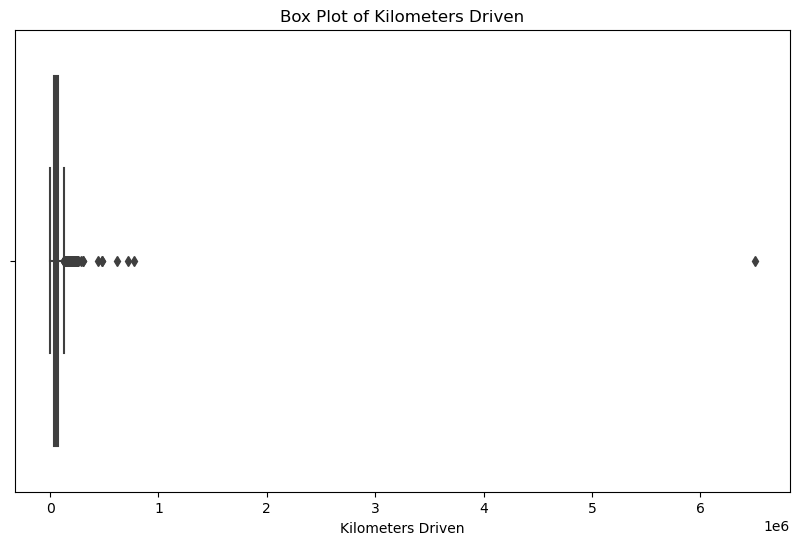

In [18]:
# Box plot for Kilometers_Driven
plt.figure(figsize=(10, 6))
sns.boxplot(x=data_encoded['Kilometers_Driven'])
plt.title('Box Plot of Kilometers Driven')
plt.xlabel('Kilometers Driven')
plt.show()

In [19]:
# Huge Outliers that make impossible to visualize the distribution of the values:
# Cap Kilometers_Driven at the 99th percentile to handle extreme outliers
upper_limit = data_encoded['Kilometers_Driven'].quantile(0.99)
data_encoded['Kilometers_Driven'] = data_encoded['Kilometers_Driven'].clip(upper=upper_limit)
data_encoded['Kilometers_Driven'].describe()

count     6019.00
mean     56933.31
std      32461.35
min        171.00
25%      34000.00
50%      53000.00
75%      73000.00
max     172829.00
Name: Kilometers_Driven, dtype: float64

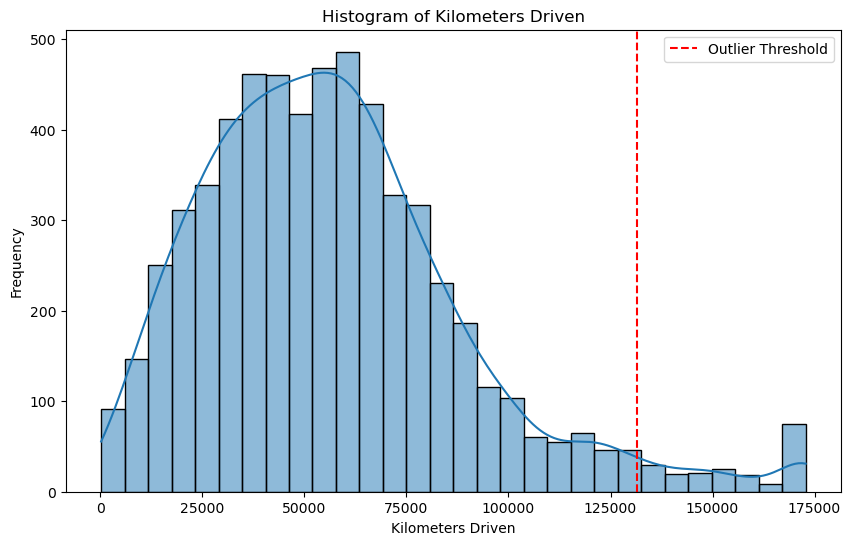

In [20]:
# Histogram for Kilometers_Driven
plt.figure(figsize=(10, 6))
sns.histplot(data_encoded['Kilometers_Driven'], bins=30, kde=True)
plt.title('Histogram of Kilometers Driven')
plt.xlabel('Kilometers Driven')
plt.ylabel('Frequency')
plt.axvline(131500, color='red', linestyle='--', label='Outlier Threshold')
plt.legend()
plt.show()

#Calculate the IQR:

#IQR = 75th percentile (73,000) - 25th percentile (34,000)
#IQR = 73,000 - 34,000 = 39,000
#Determine the upper bound for outliers:

#Outliers are often considered values that lie beyond 1.5 times the IQR above the 75th percentile.
#Upper bound = 75th percentile + 1.5 * IQR
#Upper bound = 73,000 + 1.5 * 39,000 = 73,000 + 58,500 = 131,500

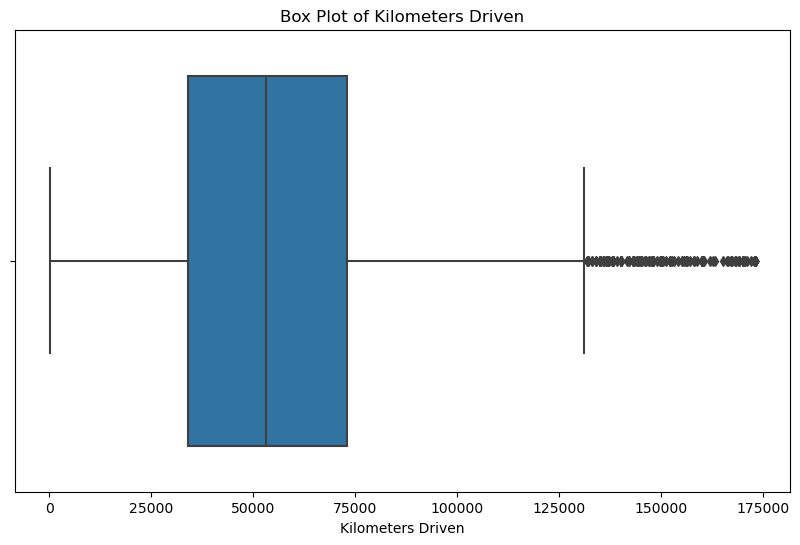

In [21]:
# Box plot for Kilometers_Driven
plt.figure(figsize=(10, 6))
sns.boxplot(x=data_encoded['Kilometers_Driven'])
plt.title('Box Plot of Kilometers Driven')
plt.xlabel('Kilometers Driven')
plt.show()

#In this boxplot we can verify the outlier threshold determined before

In [22]:
# HANDLING OUTLIERS FOR REST OF VARIABLES AS WE DID FOR KM_DRIVEN

# EXPLAIN WHAT THE FUNCTION DOES
def handle_outliers(df, column):
    # Get the 99th quantile
    q99 = df[column].quantile(0.99)
    df[column] = df[column].clip(upper=q99)
    return df

data_encoded = handle_outliers(data_encoded, 'Power')
data_encoded = handle_outliers(data_encoded, 'Engine')

# Display the updated dataframe
print(data_encoded.describe())

         Year  Kilometers_Driven  Mileage  Engine    Power   Seats  Price_USD  \
count 6019.00            6019.00  6019.00 6019.00  6019.00 6019.00    6019.00   
mean  2013.36           56933.31    18.07 1613.40  2624.60    5.28   11421.05   
std      3.27           32461.35     4.51  568.75  4391.92    0.80   13479.42   
min   1998.00             171.00     0.00   72.00    35.00    2.00     530.12   
25%   2011.00           34000.00    15.10 1198.00   140.00    5.00    4216.87   
50%   2014.00           53000.00    18.12 1493.00   838.00    5.00    6795.18   
75%   2016.00           73000.00    21.01 1969.00  1685.00    5.00   11987.95   
max   2019.00          172829.00    28.40 3161.36 18774.00   10.00  192771.08   

       Car_Age  Owner_Type_Encoded  
count  6019.00             6019.00  
mean      5.64                0.38  
std       3.27                0.82  
min       0.00                0.00  
25%       3.00                0.00  
50%       5.00                0.00  
75%       8

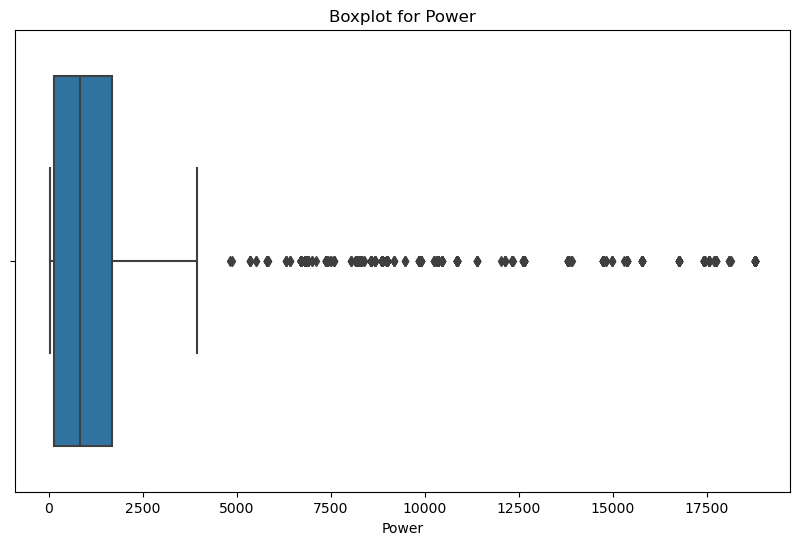

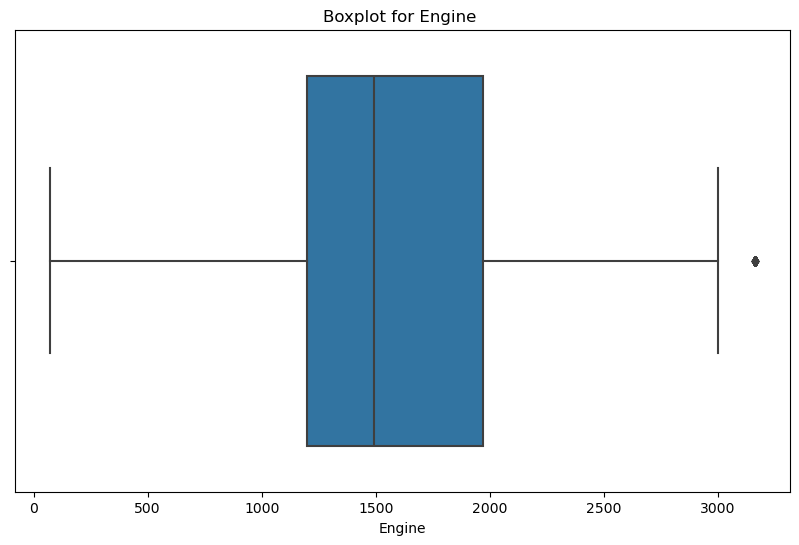

In [23]:
# Boxplot for Power after outlier handling
plt.figure(figsize=(10, 6))
sns.boxplot(x=data_encoded['Power'])
plt.title('Boxplot for Power')
plt.show()

# Boxplot for Engine after outlier handling
plt.figure(figsize=(10, 6))
sns.boxplot(x=data_encoded['Engine'])
plt.title('Boxplot for Engine ')
plt.show()

In [24]:
# As we  can visualize, this handle_outliers method we created it was useful for Engine but for Kilometers Driven and Power 
# it only got rid of extreme outliers but we still have a notable amount of them

# For that we are going to apply Square Root Transformation and Log transformation to these variables in order to handle not only outliers but also left_skewed data 
# Make a copy of the dataset to avoid modifying the original data
data_transformed = data_encoded.copy()

# Sqrt transform Kilometers_Driven and Power
data_transformed['Sqrt_Kilometers_Driven'] = np.sqrt(data_transformed['Kilometers_Driven'])
data_transformed['Log_Power'] = np.log(data_transformed['Power'])

# Summary statistics before and after transformation
print(data_encoded[['Kilometers_Driven', 'Power']].describe())
print(data_transformed[['Sqrt_Kilometers_Driven', 'Log_Power']].describe())

       Kilometers_Driven    Power
count            6019.00  6019.00
mean            56933.31  2624.60
std             32461.35  4391.92
min               171.00    35.00
25%             34000.00   140.00
50%             53000.00   838.00
75%             73000.00  1685.00
max            172829.00 18774.00
       Sqrt_Kilometers_Driven  Log_Power
count                 6019.00    6019.00
mean                   228.53       6.56
std                     68.63       1.69
min                     13.08       3.56
25%                    184.39       4.94
50%                    230.22       6.73
75%                    270.19       7.43
max                    415.73       9.84


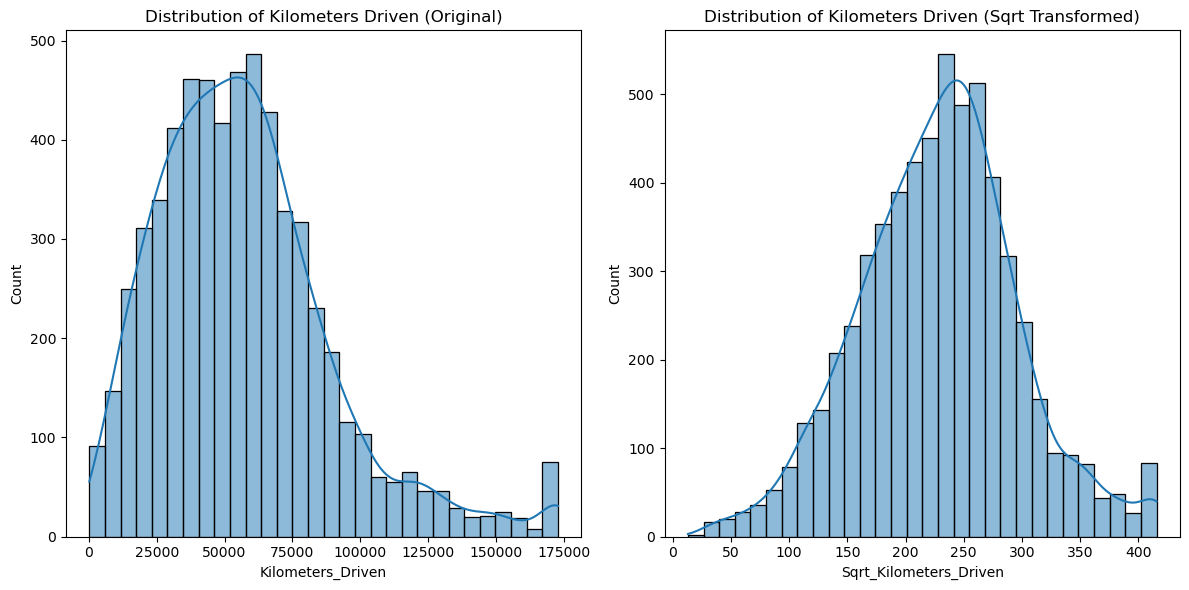

In [25]:
plt.figure(figsize=(12, 6))

# Original Kilometers_Driven
plt.subplot(1, 2, 1)
sns.histplot(data_encoded['Kilometers_Driven'], bins=30, kde=True)
plt.title('Distribution of Kilometers Driven (Original)')

# Sqrt-transformed Kilometers_Driven
plt.subplot(1, 2, 2)
sns.histplot(data_transformed['Sqrt_Kilometers_Driven'], bins=30, kde=True)
plt.title('Distribution of Kilometers Driven (Sqrt Transformed)')

plt.tight_layout()
plt.show()

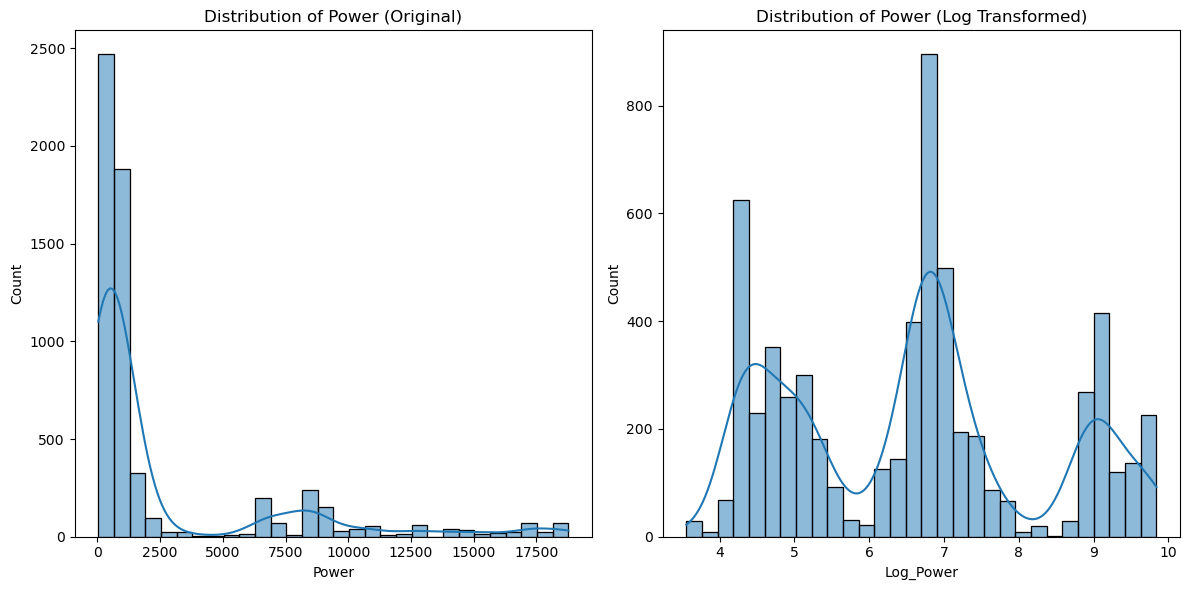

In [26]:
plt.figure(figsize=(12, 6))

# Original Power
plt.subplot(1, 2, 1)
sns.histplot(data_encoded['Power'], bins=30, kde=True)
plt.title('Distribution of Power (Original)')

# Log-transformed Power (ensure this column is in your transformed DataFrame)
plt.subplot(1, 2, 2)
sns.histplot(data_transformed['Log_Power'], bins=30, kde=True)  # Make sure Log_Power exists in your transformed DataFrame
plt.title('Distribution of Power (Log Transformed)')

plt.tight_layout()
plt.show()


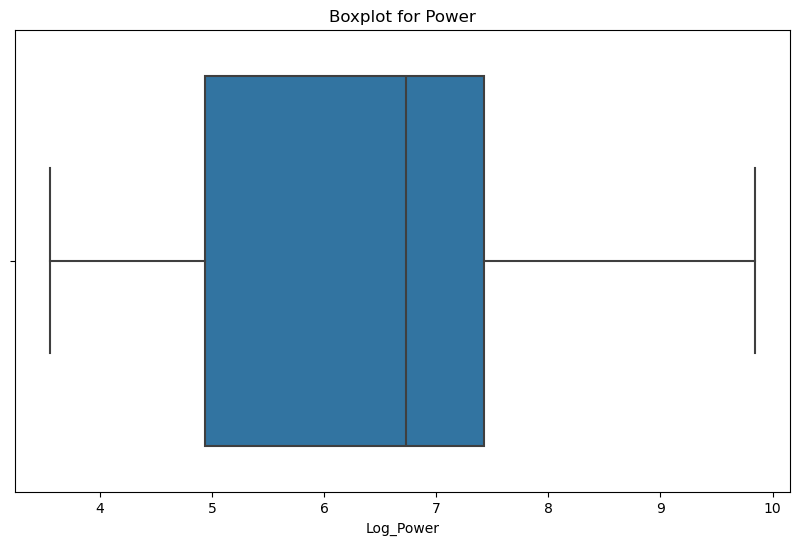

In [27]:
#SOME INSIGHT AFTER HANDLING OUTLIERS PLUS INTRO TO WHY STANDARDIZATION
plt.figure(figsize=(10, 6))
sns.boxplot(x=data_transformed['Log_Power'])
plt.title('Boxplot for Power')
plt.show()

In [28]:
# STANDARDIZE VARIABLES
from sklearn.preprocessing import StandardScaler
features_to_scale = ['Sqrt_Kilometers_Driven', 'Engine', 'Log_Power', 'Mileage']
# Initialize the scaler
scaler = StandardScaler()
# Fit and transform the features
data_transformed[features_to_scale] = scaler.fit_transform(data_transformed[features_to_scale])

# Check results:
data_transformed.describe()

,Year,Kilometers_Driven,Mileage,Engine,Power,Seats,Price_USD,Car_Age,Owner_Type_Encoded,Sqrt_Kilometers_Driven,Log_Power
count,6019.00,6019.00,6019.00,6019.00,6019.00,6019.00,6019.00,6019.00,6019.00,6019.00,6019.00
mean,2013.36,56933.31,-0.00,0.00,2624.60,5.28,11421.05,5.64,0.38,0.00,0.00
std,3.27,32461.35,1.00,1.00,4391.92,0.80,13479.42,3.27,0.82,1.00,1.00
min,1998.00,171.00,-4.00,-2.71,35.00,2.00,530.12,0.00,0.00,-3.14,-1.78
25%,2011.00,34000.00,-0.66,-0.73,140.00,5.00,4216.87,3.00,0.00,-0.64,-0.96
50%,2014.00,53000.00,0.01,-0.21,838.00,5.00,6795.18,5.00,0.00,0.02,0.10
75%,2016.00,73000.00,0.65,0.63,1685.00,5.00,11987.95,8.00,0.00,0.61,0.52
max,2019.00,172829.00,2.29,2.72,18774.00,10.00,192771.08,21.00,3.00,2.73,1.95


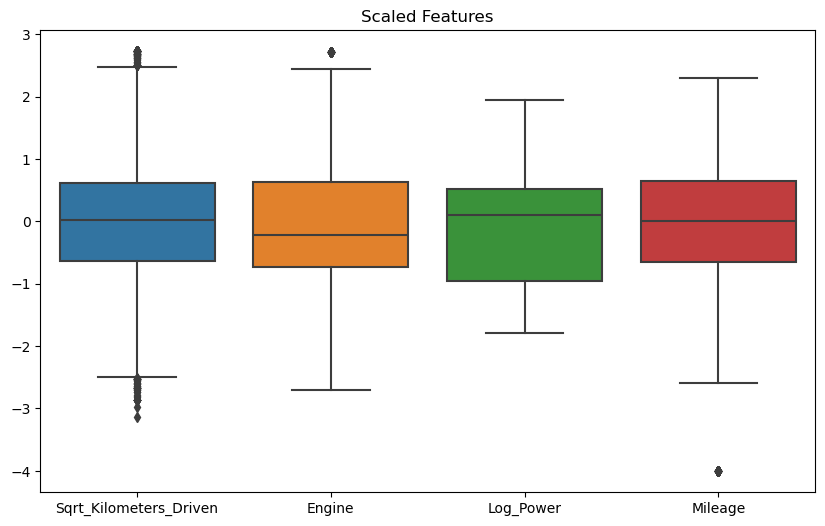

In [29]:
scaled_features = ['Sqrt_Kilometers_Driven', 'Engine', 'Log_Power', 'Mileage']

# Create a boxplot
plt.figure(figsize=(10, 6))
sns.boxplot(data=data_transformed[scaled_features])
plt.title('Scaled Features')
plt.show()

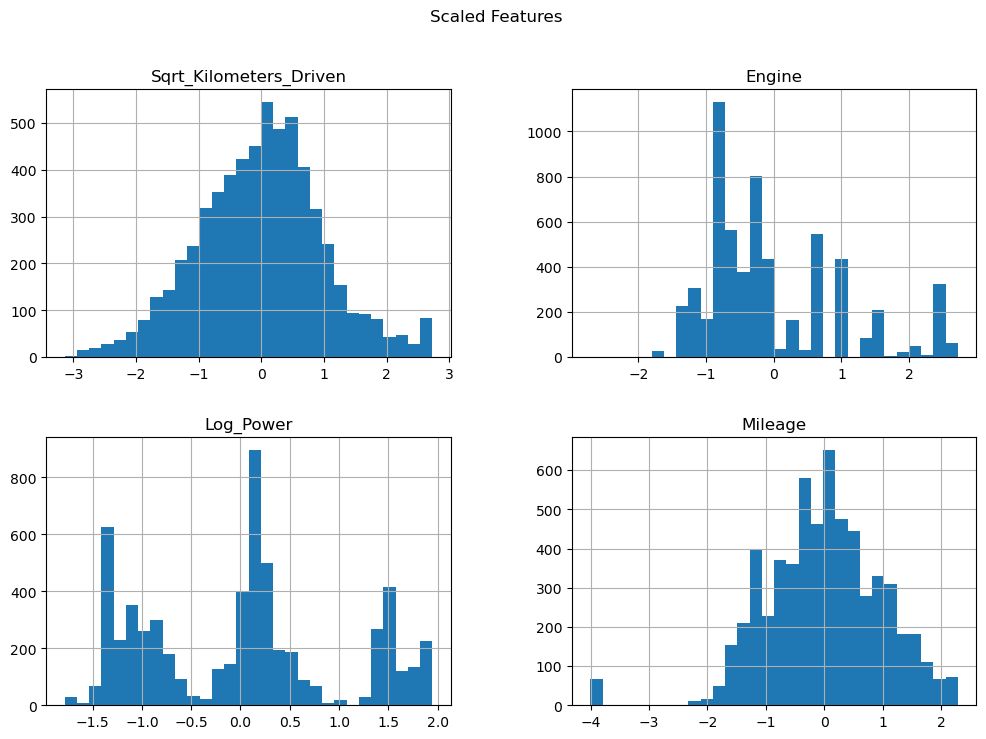

In [30]:
# Histogram for each scaled feature
data_transformed[scaled_features].hist(bins=30, figsize=(12, 8))
plt.suptitle('Scaled Features')
plt.show()

In [31]:
# Correlation matrix
cor_var = ['Price_USD','Sqrt_Kilometers_Driven','Mileage','Log_Power','Seats','Car_Age', 'Engine', 'Owner_Type_Encoded']
data = data_transformed[cor_var]
data.corr()

,Price_USD,Sqrt_Kilometers_Driven,Mileage,Log_Power,Seats,Car_Age,Engine,Owner_Type_Encoded
Price_USD,1.00,-0.20,-0.30,0.11,0.05,-0.31,0.64,-0.09
Sqrt_Kilometers_Driven,-0.20,1.00,-0.15,-0.16,0.22,0.53,0.18,0.24
Mileage,-0.30,-0.15,1.00,0.07,-0.30,-0.33,-0.59,-0.16
Log_Power,0.11,-0.16,0.07,1.00,-0.11,-0.23,0.00,-0.09
Seats,0.05,0.22,-0.30,-0.11,1.00,-0.01,0.43,0.00
Car_Age,-0.31,0.53,-0.33,-0.23,-0.01,1.00,0.05,0.39
Engine,0.64,0.18,-0.59,0.00,0.43,0.05,1.00,0.05
Owner_Type_Encoded,-0.09,0.24,-0.16,-0.09,0.00,0.39,0.05,1.00


**Price_USD vs. Engine**: The high positive correlation (0.64) suggests that as the engine size increases, the price of the car increases, which makes sense since larger engines are typically found in more expensive cars.

**Price_USD vs. Car_Age**: The negative correlation (-0.31) indicates that as cars get older, their price decreases, which is intuitive.

**Price_USD vs. Mileage**: A negative correlation (-0.30) is reasonable because cars with higher mileage (better fuel efficiency) are often more economical and may have lower price tags.

**Price_USD vs. Kilometers_Driven**: The weak negative correlation (-0.20) with Price_USD  suggest that while higher km generally lowers price.

<Axes: >

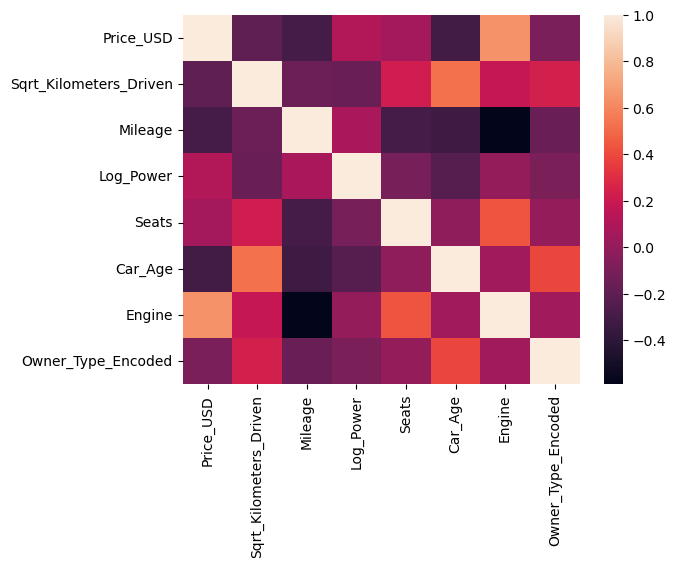

In [32]:
sns.heatmap(data.corr())

## **DATA SPLIT**

In [33]:
# Split the dataset
from sklearn.model_selection import train_test_split

# Start with a model of predictors of the most 
predictors = ['Sqrt_Kilometers_Driven', 'Mileage', 'Log_Power', 'Seats', 'Car_Age', 'Engine', 'Owner_Type_Encoded', 'Fuel_Type_Diesel',	'Fuel_Type_Electric', 'Fuel_Type_LPG', 'Fuel_Type_Petrol']
data_X = data_transformed[predictors]
data_Y = data_transformed['Price_USD']

#Randomly split the dataset into 70% training and 30% validation.
X_train, X_test, y_train, y_test = train_test_split(data_X, data_Y, test_size=0.3, random_state=42)

# show number of observations in the training set and the test set
X_train.shape[0], X_test.shape[0]

(4213, 1806)

## **MODEL SELECTION**

- Recall that our objective is to develop a regression model that predicts the price of used cars.
- For that, we will train a few different models from simpler ones like linear regression to more complexs like KNN

**Linear Regression**

In [34]:
# As we said we will start with simple models like linear regression, and it will be used as a benchmark for the rest of the models:
## LINEAR REGRESSION:
from sklearn.linear_model import LinearRegression
lr = LinearRegression()

# Fit the model
lr.fit(X_train, y_train)

# Print out the coefficients
lr.coef_, lr.intercept_

(array([-2280.38786814, -1689.93565399,   146.16879507, -4974.15988361,
        -1181.34818561,  9174.24670673,   285.56410854,  1135.97541992,
        24420.98736615,  1410.35025345, -2355.9461051 ]),
 44605.90738516764)

**y** = -1713.6555184 * **x_'Sqrt_Km_Driven'** - 613.42680669 * **x_'Mileage'** - 84.86016032 * **x_'Log_Power'** - 3758.50189519 * **x_'Seats'** - 992.86286798 * **x_'Car_Age'** + 8591.77217244 * **x_'Engine'** + 36052.22401608031

In [35]:
# Test set prediction
y_pred_test = lr.predict(X_test)

# Model Performance measured with MAE, MSE, R^2:
print(mae(y_test, y_pred_test), mse(y_test, y_pred_test) ,r2_score(y_test, y_pred_test))


5416.937480994505 68781541.62948115 0.6147632688748518


In [36]:
# Faster performance measure:
lr.score(X_test, y_test), lr.score(X_train, y_train)

(0.6147632688748518, 0.6140175775447275)

As we clarified before, this linear regression model is going to be used as a benchmark as it is the simplest one of all

**RANDOM FOREST**

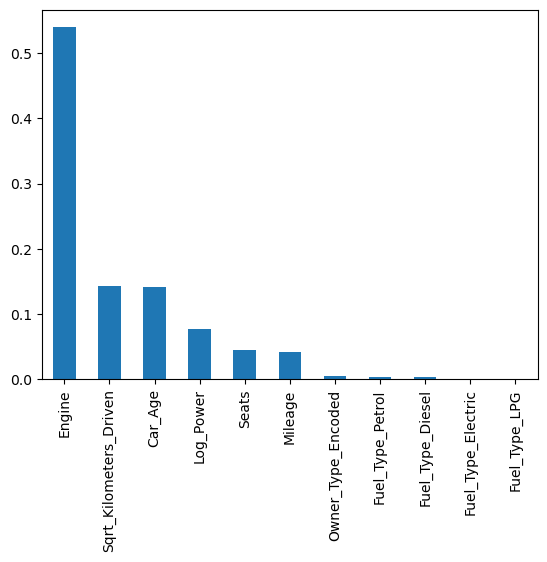

In [37]:
# RANDOM FOREST:
from sklearn.ensemble import RandomForestRegressor
# Train a random forest model
rf = RandomForestRegressor()
rf.fit(X_train, y_train)

# Get feature importance
importance = pd.Series(rf.feature_importances_, index=X_train.columns)

# Plot feature importance
importance.sort_values(ascending=False).plot(kind='bar')
plt.show()

In [38]:
# Test set prediction
y_pred_test = rf.predict(X_test)

# Model Performance measured with MAE, MSE, R^2:
print(mae(y_test, y_pred_test), mse(y_test, y_pred_test) ,r2_score(y_test, y_pred_test))

2316.9033063117845 28299075.183900278 0.8415004526005303


In [39]:
rf.score(X_test, y_test), rf.score(X_train, y_train)

(0.8415004526005303, 0.9796836805733801)

In [40]:
from sklearn.model_selection import cross_val_score

# Mean cross-validated R^2 score
scores = cross_val_score(rf, X_train, y_train, cv=5, scoring='r2')
print(scores.mean())  


0.8516155897434569


- The noticeable difference between the training and test accuracies suggests that the model might be overfitting to the training data.
- We will try simpler model just with the most important variables acording to our randomforest model:

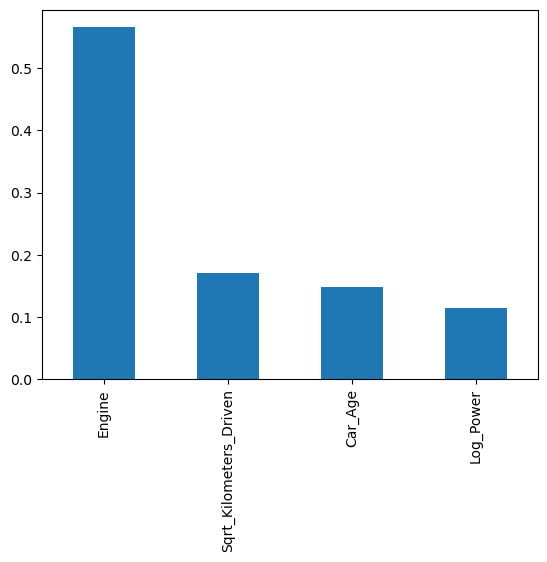

(0.8306461399642955, 0.9781028047124856)

In [41]:
model2 = ['Engine','Sqrt_Kilometers_Driven', 'Car_Age', 'Log_Power']
data_X2 = data_transformed[model2]
data_Y2 = data_transformed['Price_USD']

#Randomly split the dataset into 70% training and 30% validation.
X_train2, X_test2, y_train2, y_test2 = train_test_split(data_X2, data_Y2, test_size=0.3, random_state=42)

rf2 = RandomForestRegressor()
rf2.fit(X_train2, y_train2)

# Get feature importance
importance2 = pd.Series(rf2.feature_importances_, index=X_train2.columns)

# Plot feature importance
importance2.sort_values(ascending=False).plot(kind='bar')
plt.show()

rf2.score(X_test2, y_test2), rf2.score(X_train2, y_train2)

**Hyperparameter Tuning**

In [42]:
from sklearn.model_selection import GridSearchCV

# Define parameter grid for tuning
param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [10, 15, 20],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

# Perform grid search
grid_search = GridSearchCV(estimator=rf, param_grid=param_grid, cv=5, scoring='r2', n_jobs=-1)
grid_search.fit(X_train, y_train)

# Get the best parameters
print(grid_search.best_params_)

# Train the RandomForestRegressor with best parameters
best_rf = grid_search.best_estimator_
best_rf.fit(X_train, y_train)


{'max_depth': 20, 'min_samples_leaf': 1, 'min_samples_split': 5, 'n_estimators': 300}


RandomForestRegressor(max_depth=20, min_samples_split=5, n_estimators=300)

In [43]:
best_scores = cross_val_score(best_rf, X_train, y_train, cv=5, scoring='r2')
print(scores.mean())

0.8516155897434569


In [44]:
best_rf.score(X_test, y_test), best_rf.score(X_train, y_train)

(0.842850557137512, 0.9677042190371403)

**Ridge Regression**

In [45]:
from sklearn.linear_model import Ridge

ridge = Ridge(alpha=1)  
ridge.fit(X_train, y_train)

print(ridge.score(X_test, y_test), ridge.score(X_train, y_train))

0.6159665037704942 0.6138240979810361


In [46]:
# 1. Define a list of parameters (key is 'alpha')
param_ridge = {'alpha': [0.001, 0.01, 0.1, 1, 10, 100] }

# 2. Define function and fit the data
grid_ridge = Ridge()
grid_ridge_est = GridSearchCV(grid_ridge, param_ridge, cv=5)
grid_ridge_est.fit(X_train, y_train)

# 3.1 Present performance measure
print(grid_ridge_est.best_score_)

# 3.2 find best hyperparameters
print(grid_ridge_est.best_params_)

# 3.3 find best parameter estimates
print(grid_ridge_est.score(X_test, y_test), grid_ridge_est.score(X_train, y_train))

0.6109360552566564
{'alpha': 100}
0.6170278251956614 0.6125410284821173


**Lasso Regression**

In [47]:
from sklearn.linear_model import Lasso

lasso_reg = Lasso(alpha=1)
lasso_reg.fit(X_train, y_train)

Lasso(alpha=1)

In [48]:
# Grid Search with CV - LASSO Case

# 1. Define a list of parameters (key is 'alpha')
param_lasso = {'alpha': [0, 0.00001, 0.0001, 0.001, 0.01, 0.1, 1, 10, 100] }

# 2. Define function and fit the data
grid_lasso = Lasso()
grid_lasso_est = GridSearchCV(grid_lasso, param_lasso, cv=5)
grid_lasso_est.fit(X_train, y_train)

# 3.1 Present performance measure
print(grid_lasso_est.best_score_)

# 3.2 find best hyperparameters
print(grid_lasso_est.best_params_)

# 3.3 find best parameter estimates
print(grid_lasso_est.score(X_test, y_test), grid_lasso_est.score(X_train, y_train))

0.6108629254228981
{'alpha': 10}
0.6165734371710976 0.6132506409243351


**KNN**

In [49]:
from sklearn.neighbors import KNeighborsRegressor
# Initialize the KNN regressor
knn = KNeighborsRegressor(n_neighbors=5)

# Train the KNN model
knn.fit(X_train, y_train)

# Predict on the test set
y_pred_test = knn.predict(X_test)

# Evaluate the performance 
mse_test = mse(y_test, y_pred_test)
r2_test = r2_score(y_test, y_pred_test)


print(f"Test MSE: {mse_test}")
print(f"Test R²: {r2_test}")

# Perform cross-validation on training data
cv_scores = cross_val_score(knn, X_train, y_train, cv=5, scoring='r2')
print(f"Cross-validated R² score: {cv_scores.mean()}")

param_grid = {'n_neighbors': range(1, 20)}

# Perform grid search
grid_search = GridSearchCV(KNeighborsRegressor(), param_grid, cv=5, scoring='r2', n_jobs=-1)
grid_search.fit(X_train, y_train)

# Best number of neighbors
print(f"Best number of neighbors: {grid_search.best_params_['n_neighbors']}")

# Use the best model
best_knn = grid_search.best_estimator_
best_knn.fit(X_train, y_train)

# Predict and evaluate
y_pred_best = best_knn.predict(X_test)
print(f"Best Test R²: {r2_score(y_test, y_pred_best)}")

Test MSE: 43637736.90607605
Test R²: 0.7555905447721092
Cross-validated R² score: 0.7387856449971754
Best number of neighbors: 4
Best Test R²: 0.7453156100676601


   | Model              | Test R²        | Training R²   | Notes                                                                                     |
|--------------------|----------------|---------------|-------------------------------------------------------------------------------------------|
| **Linear Regression** | 0.6148         | 0.6140        | Moderate performance, with very close train and test R², indicating no major overfitting.  |
| **Random Forest**     | 0.8384         | 0.8529        | Best performing model in terms of R². Slightly higher train R², suggesting slight overfitting. |
| **Ridge**             | 0.6170         | 0.6125        | Similar performance to Linear Regression; Ridge regularization doesn’t add significant improvement. |
| **Lasso**             | 0.6166         | 0.6133        | Performance nearly identical to Ridge and Linear Regression. Lasso doesn’t show significant gains here. |
| **KNN**               | 0.7556         | 0.7388        | Strong performance, though not as high as Random Forest. Close train-test R² shows good generalization. |
